# Create image csv file


In [1]:
import os
import csv

# Image path
# image_folder = "/local/data1/honzh073/data/8bit_downsample"
image_folder = "/local/data1/honzh073/data/8bit_downsample"

# CSV path
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/2_patient_level/image_data.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Create a CSV writer object and write the header
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through files in the folder
    for filename in sorted(os.listdir(image_folder)):
        # Construct the complete image file path
        image_path = os.path.join(image_folder, filename)

        # Parse the filename to extract HospitalID, PatientID, image number, and image label
        parts = filename.split('_')
        hospital_id = parts[3]
        patient_id = parts[1]
        image_number = parts[6]
        image_label = parts[4]

        # Write data into the CSV file
        writer.writerow({
            'HospitalID': hospital_id,
            'PatientID': patient_id,
            'ImageID': image_number,
            'ImagePath': image_path,
            'Label': image_label
        })

# Print a message indicating that the CSV file has been created and saved
print("csv file:", csv_file_path)


csv file: /local/data1/honzh073/local_repo/FL/code/2_patient_level/image_data.csv


# Split csv files by patient ID

In [2]:
import csv
from collections import defaultdict
import random


input_csv_path = "/local/data1/honzh073/local_repo/FL/code/2_patient_level/image_data.csv"
patient_data = defaultdict(list)

with open(input_csv_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        patient_id = row['PatientID']
        patient_data[patient_id].append(row)

num_patients = len(patient_data)

# ratio
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

num_train = int(num_patients * train_ratio)
num_val = int(num_patients * val_ratio)
num_test = num_patients - num_train - num_val

# get random IDs
all_patient_ids = list(patient_data.keys())

random.seed(1)
random.shuffle(all_patient_ids)

# split by ID
train_patients = all_patient_ids[ : num_train]
val_patients = all_patient_ids[num_train : num_train + num_val]
test_patients = all_patient_ids[num_train + num_val : ]

# iter by patient IDs
train_data = []
val_data = []
test_data = []

for patient_id, images in patient_data.items():
    if patient_id in train_patients:
        train_data.extend(images)
    elif patient_id in val_patients:
        val_data.extend(images)
    elif patient_id in test_patients:
        test_data.extend(images)

# write to csv
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/train.csv', train_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/val.csv', val_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/2_patient_level/test.csv', test_data)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# change first layer to single channel image input
def first_layer(model):
    pretrained_weights = model.conv1.weight
    new_weights = torch.nn.Parameter(pretrained_weights[:, 0:1, :, :])
    model.conv1.weight = new_weights
    
    return model

# get training class weight, aff : nff = 2:8
def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]   

# training function
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name):
    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # freeze all layers except full connection layer
    
    # for param in model.parameters():
    #     param.requires_grad = False
        
    model = first_layer(model)
    
    num_class = 2 # binary classification
    
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(0.4),nn.Linear(in_features, num_class))
        model.classifier = nn.Sequential(nn.Linear(in_features, num_class))

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(in_features, num_class))
        model.fc = nn.Sequential(nn.Dropout(0.4), nn.Linear(in_features, num_class))
    
    # device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # DataParallel speed up?
    if torch.cuda.device_count() > 1:
        print("multiple GPU:", torch.cuda.device_count())
        model = nn.DataParallel(model)
    else:
        print("single GPU")
        model = model.to(device)


    # Loss, optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
    # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    # select best model
    best_validation_accuracy = 0.0
    best_model = None
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler
        
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_model = model.module  # DataParallel
            # best_model = model  # single device
            
    # Plot train/val loss,  accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return best_model

def test_model(model, test_dataset, batch_size):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}  # Define your class labels here

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        # plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
    

training class weight [0.6176470588235294, 2.625]
Image location: /local/data1/honzh073/data/8bit_downsample/patient_JLPLAOUOKS_hospital_6_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_PTJLNYLQLO_hospital_55_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_JQRZYJFXHO_hospital_18_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_BGPFUVHNCO_hospital_100_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_LHGYFKFHKZ_hospital_100_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_CQMUSXXISF_hospital_13_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_DPBVSYMRXO_hospital_33_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_VDZVIQHCNV_hospital_21_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_UPXCHBNTHF_hospital_100_NFF_image_

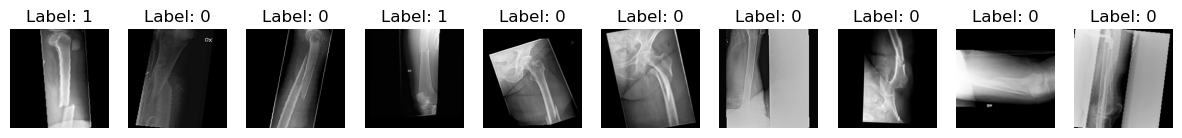

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 504, ratio: 0.19
----- NFF: 2142, ratio: 0.81
-----------------------------------
val AFF: 172, ratio: 0.20
--- NFF: 671, ratio: 0.80
-----------------------------------
test AFF: 192, ratio: 0.23
---- NFF: 661, ratio: 0.77


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv

# read image, image by csv. Custom dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('L')  # 'L' to gray image

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transforms for training data

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomVerticalFlip(p=1),
#     transforms.RandomRotation(degrees=(0, 180)),
#     transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.3),
#     # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
#     # transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 5)),
#     # transforms.RandomInvert(),
#     # transforms.RandomPosterize(bits=2),
#     transforms.RandomAdjustSharpness(sharpness_factor=4),
#     # transforms.RandomAutocontrast(),
#     # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
#     # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize(mean=[0.5], std=[0.5]),

# ])


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # gray iamge 0 to 1
])

# only use     transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),    transforms.RandomAdjustSharpness(sharpness_factor=4),
# which has a better performance

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', transform=test_transform)

# repeated_dataset = torch.utils.data.ConcatDataset([train_dataset] * 30)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

show_image(train_dataset, 10)

print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
AFF_label = 'AFF'
NFF_label = 'NFF'

# propotion of aff and nff in datasets
train_AFF_count = sum(1 for row in train_data if row['Label'] == AFF_label)
train_NFF_count = sum(1 for row in train_data if row['Label'] == NFF_label)

val_AFF_count = sum(1 for row in val_data if row['Label'] == AFF_label)
val_NFF_count = sum(1 for row in val_data if row['Label'] == NFF_label)

test_AFF_count = sum(1 for row in test_data if row['Label'] == AFF_label)
test_NFF_count = sum(1 for row in test_data if row['Label'] == NFF_label)

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"val AFF: {val_AFF_count}, ratio: {val_AFF_count / (val_AFF_count + val_NFF_count):.2f}")
print(f"--- NFF: {val_NFF_count}, ratio: {val_NFF_count / (val_AFF_count + val_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

when set the transforms as below:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
    # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # gray iamge 0 to 1
])
it has a better performance, and fast converge.


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.5860, val Loss: 0.6605, train ACC: 54.38%, Val ACC: 67.38%
Epoch 2/50, train Loss: 0.3721, val Loss: 0.5138, train ACC: 72.34%, Val ACC: 79.24%
Epoch 3/50, train Loss: 0.4053, val Loss: 0.3939, train ACC: 81.37%, Val ACC: 84.58%
Epoch 4/50, train Loss: 0.2514, val Loss: 0.3294, train ACC: 85.19%, Val ACC: 90.51%
Epoch 5/50, train Loss: 0.2248, val Loss: 0.6485, train ACC: 89.68%, Val ACC: 88.73%
Epoch 6/50, train Loss: 0.3945, val Loss: 0.3061, train ACC: 89.19%, Val ACC: 90.75%
Epoch 7/50, train Loss: 0.5795, val Loss: 0.2948, train ACC: 91.04%, Val ACC: 88.49%
Epoch 8/50, train Loss: 0.1930, val Loss: 0.2819, train ACC: 91.69%, Val ACC: 91.22%
Epoch 9/50, train Loss: 0.2439, val Loss: 0.3219, train ACC: 93.27%, Val ACC: 92.41%
Epoch 10/50, train Loss: 0.1549, val Loss: 0.2474, train ACC: 92.86%, Val ACC: 89.32%
Epoch 11/50, train Loss: 0.1146, val Loss: 0.2532, train ACC: 93.65%, Val ACC: 92.05%
Epoch 12/50, train Loss: 0.1284, val Loss: 0.2498, train ACC: 9

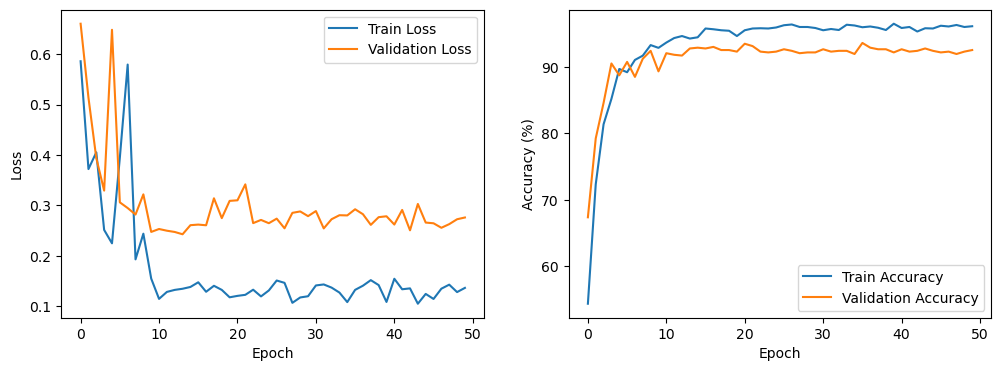

In [5]:
epoch_num = 50
# dont preset lr and step_size, because each net has a different learning curve
# resnet50
resnet50 = train_model(train_loader, val_loader,
                       classweight=classweight,
                       num_epochs=epoch_num,
                       lr=0.0001, step_size=10, gamma=0.1,
                       model_name='resnet50')


Test Loss: 0.2198, Test Acc: 90.86%
AUC: 0.8763276916288453
Confusion Matrix:
[[618  43]
 [ 35 157]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.95      0.93      0.94       661
         AFF       0.79      0.82      0.80       192

    accuracy                           0.91       853
   macro avg       0.87      0.88      0.87       853
weighted avg       0.91      0.91      0.91       853



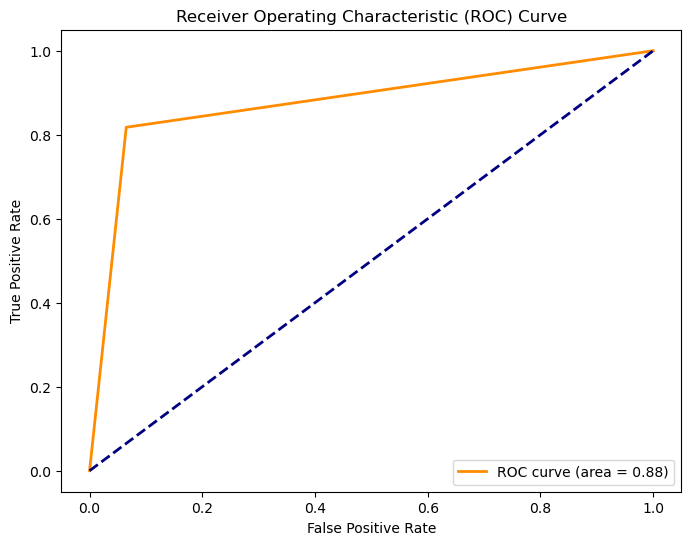

In [6]:
test_model(model=resnet50, test_dataset=test_dataset, batch_size=batch_size)


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.5867, val Loss: 0.6147, train ACC: 64.78%, Val ACC: 69.28%
Epoch 2/50, train Loss: 0.5188, val Loss: 0.5055, train ACC: 74.19%, Val ACC: 74.73%
Epoch 3/50, train Loss: 0.5478, val Loss: 0.3689, train ACC: 82.84%, Val ACC: 80.43%
Epoch 4/50, train Loss: 0.5163, val Loss: 0.3895, train ACC: 87.30%, Val ACC: 74.38%
Epoch 5/50, train Loss: 0.2905, val Loss: 0.2931, train ACC: 90.06%, Val ACC: 89.68%
Epoch 6/50, train Loss: 0.3741, val Loss: 0.2795, train ACC: 91.23%, Val ACC: 91.58%
Epoch 7/50, train Loss: 0.1440, val Loss: 0.2818, train ACC: 92.86%, Val ACC: 88.85%
Epoch 8/50, train Loss: 0.1807, val Loss: 0.2611, train ACC: 93.99%, Val ACC: 90.27%
Epoch 9/50, train Loss: 0.1066, val Loss: 0.2558, train ACC: 94.48%, Val ACC: 92.76%
Epoch 10/50, train Loss: 0.0645, val Loss: 0.2724, train ACC: 94.03%, Val ACC: 93.95%
Epoch 11/50, train Loss: 0.0970, val Loss: 0.2594, train ACC: 94.63%, Val ACC: 92.88%
Epoch 12/50, train Loss: 0.1266, val Loss: 0.2705, train ACC: 9

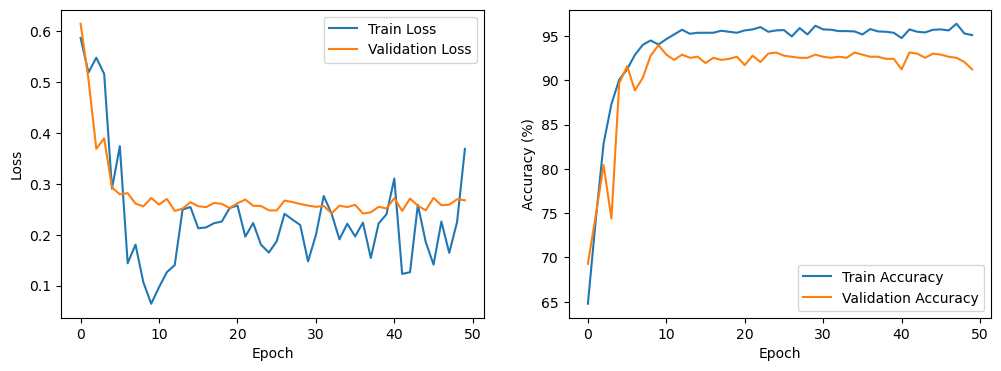

In [7]:
# resnet101
resnet101 = train_model(train_loader, val_loader, classweight, num_epochs=epoch_num, lr=0.0001, step_size=7, gamma=0.1, model_name='resnet101')


Test Loss: 0.3084, Test Acc: 87.22%
AUC: 0.8732034795763994
Confusion Matrix:
[[576  85]
 [ 24 168]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.96      0.87      0.91       661
         AFF       0.66      0.88      0.76       192

    accuracy                           0.87       853
   macro avg       0.81      0.87      0.83       853
weighted avg       0.89      0.87      0.88       853



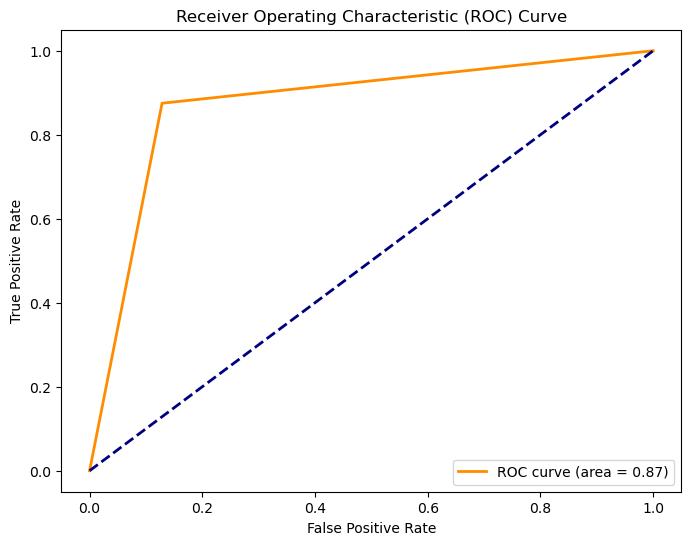

In [8]:
test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size)


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.6648, val Loss: 0.6628, train ACC: 58.05%, Val ACC: 79.12%
Epoch 2/50, train Loss: 0.4721, val Loss: 0.4998, train ACC: 68.78%, Val ACC: 77.58%
Epoch 3/50, train Loss: 0.3528, val Loss: 0.4023, train ACC: 84.24%, Val ACC: 87.43%
Epoch 4/50, train Loss: 0.2439, val Loss: 0.3933, train ACC: 88.17%, Val ACC: 90.87%
Epoch 5/50, train Loss: 0.3773, val Loss: 0.3299, train ACC: 91.53%, Val ACC: 79.83%
Epoch 6/50, train Loss: 0.1730, val Loss: 0.2283, train ACC: 91.84%, Val ACC: 91.81%
Epoch 7/50, train Loss: 0.3183, val Loss: 0.2151, train ACC: 91.91%, Val ACC: 93.48%
Epoch 8/50, train Loss: 0.2870, val Loss: 0.2013, train ACC: 94.10%, Val ACC: 92.88%
Epoch 9/50, train Loss: 0.3859, val Loss: 0.2631, train ACC: 94.41%, Val ACC: 89.32%
Epoch 10/50, train Loss: 0.2373, val Loss: 0.1961, train ACC: 94.94%, Val ACC: 94.31%
Epoch 11/50, train Loss: 0.2624, val Loss: 0.2041, train ACC: 95.80%, Val ACC: 94.19%
Epoch 12/50, train Loss: 0.2353, val Loss: 0.2064, train ACC: 9

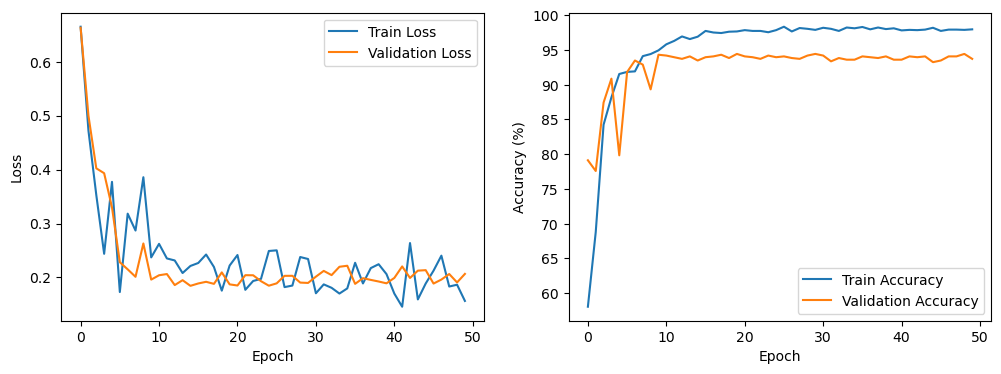

In [9]:
# resnet152
resnet152 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet152')


Test Loss: 0.2174, Test Acc: 92.50%
AUC: 0.8943086548159352
Confusion Matrix:
[[628  33]
 [ 31 161]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.95      0.95      0.95       661
         AFF       0.83      0.84      0.83       192

    accuracy                           0.92       853
   macro avg       0.89      0.89      0.89       853
weighted avg       0.93      0.92      0.93       853



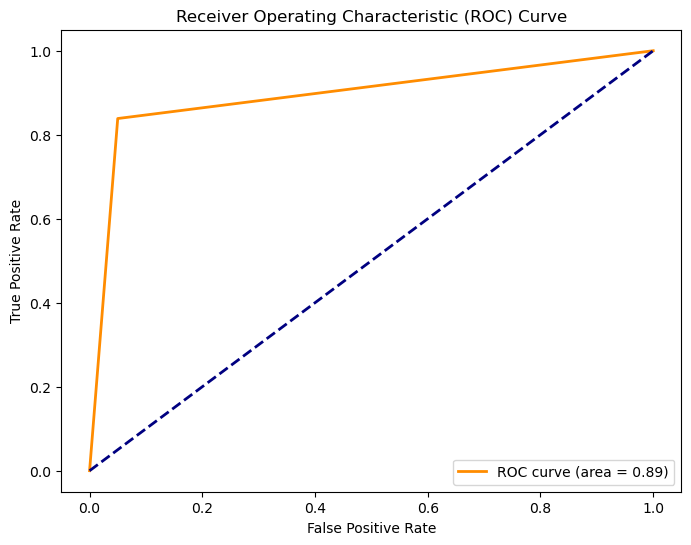

In [10]:
test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size)

In [11]:
# densenet161
densenet161 = train_model(train_loader, val_loader, classweight, 
                          num_epochs=epoch_num, lr=0.0001, step_size=10, gamma=0.1, model_name='densenet161')


AttributeError: 'DenseNet' object has no attribute 'conv1'

In [ ]:
test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size)